In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.datasets import make_circles, make_moons

import scipy

import torch
import torch.nn as nn
import math

In [2]:
class Gaussian(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.mean = nn.Parameter(torch.tensor([0], dtype=torch.float32, requires_grad=True))
        self.var = nn.Parameter(torch.tensor([1], dtype=torch.float32, requires_grad=True))
        
    def forward(self, x):
        return torch.exp(-0.5*(x-self.mean)**2/self.var) / torch.sqrt(2*self.var*np.pi)
    
    def NLL(self, x):
        t1 = -1/(2*self.var)*torch.mean((x-self.mean)**2) - torch.log(self.var)/2
        return t1

In [3]:
# inp = torch.randn(200,1)*3-1
inp = torch.rand(200)*5-1
targ = torch.ones_like(inp)/len(inp) 
gaus = Gaussian()

In [4]:
optim = torch.optim.SGD(gaus.parameters(), lr=0.5)
criterion = nn.MSELoss()

In [5]:
for i in range(1000):
    NLL = -gaus.NLL(inp)
    optim.zero_grad()
    NLL.backward()
    optim.step()
    if i%10 == 0:
        print("NLL: ", float(NLL))
        print(f"Mean: {gaus.mean.data[0]}, Variance: {gaus.var.data[0]}")

NLL:  2.047778844833374
Mean: 0.7194718718528748, Variance: 1.773889422416687
NLL:  0.8537141680717468
Mean: 1.4055497646331787, Variance: 1.9505282640457153
NLL:  0.8528896570205688
Mean: 1.4371598958969116, Variance: 1.9868594408035278
NLL:  0.8528124094009399
Mean: 1.438844084739685, Variance: 2.005049467086792
NLL:  0.8527920842170715
Mean: 1.4389382600784302, Variance: 2.01446795463562
NLL:  0.8527865409851074
Mean: 1.43894362449646, Variance: 2.019413471221924
NLL:  0.8527848720550537
Mean: 1.4389437437057495, Variance: 2.022028923034668
NLL:  0.8527845144271851
Mean: 1.4389437437057495, Variance: 2.0234172344207764
NLL:  0.8527843356132507
Mean: 1.4389437437057495, Variance: 2.024155616760254
NLL:  0.852784276008606
Mean: 1.4389437437057495, Variance: 2.0245490074157715
NLL:  0.852784276008606
Mean: 1.4389437437057495, Variance: 2.0247585773468018
NLL:  0.852784276008606
Mean: 1.4389437437057495, Variance: 2.0248703956604004
NLL:  0.852784276008606
Mean: 1.4389437437057495, Vari

In [6]:
yout = gaus(inp)

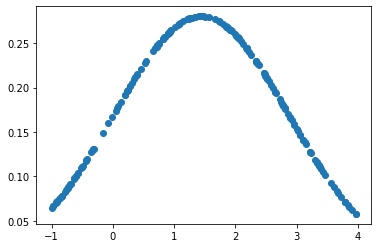

In [7]:
plt.scatter(inp.data.numpy(), yout.data.numpy())

In [8]:
print(f"GD   -> Mean: {gaus.mean.data[0]}, Variance: {gaus.var.data[0]}")
print(f"Torch-> Mean: {torch.mean(inp)}, Variance: {torch.var(inp)}")

GD   -> Mean: 1.4389437437057495, Variance: 2.024995803833008
Torch-> Mean: 1.4389439821243286, Variance: 2.0351738929748535


In [9]:
torch.sum(yout)

tensor(37.4341, grad_fn=<SumBackward0>)

In [10]:
# https://github.com/mhdadk/Maximum-Likelihood-Estimation/blob/master/mle_gaussian.ipynb

## For Bandpass Distribution

In [11]:
# %timeit math.gamma(1/4)

In [12]:
# %timeit scipy.special.gamma(1/4)

In [13]:
# v = torch.tensor([1/4])
# math.gamma(1/4), scipy.special.gamma(1/4), float(torch.lgamma(v).exp()[0])

In [14]:
# %timeit torch.lgamma(v).exp()

In [15]:
# class Bandpass(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         ##mean, var, a
#         self.params = nn.Parameter(torch.tensor([0, 1, 1], dtype=torch.float32, requires_grad=True))
        
#     def forward(self, x):
#         n1 = torch.exp(-((torch.abs(x-self.params[0]))/self.params[1])**(4*self.params[2]))
#         d1 = self.params[1]*0.25/self.params[2] * math.gamma(0.25/float(self.params[2]))
# #         d1 = self.params[1]*0.25/self.params[2] * torch.lgamma(0.25/self.params[2]).exp()
#         return  n1/d1
    
#     def NLL(self, x):
#         t1 = torch.mean(((torch.abs(x-self.params[0]))/self.params[1])**(4*self.params[2]))
# #         t2 = torch.log(0.25/self.params[2] * math.gamma(0.25/float(self.params[2])))
#         t2 = torch.log(0.25/self.params[2] * math.gamma(0.25/self.params[2]))
# #         t2 = torch.log(0.25/self.params[2] * torch.lgamma(0.25/self.params[2]).exp())
# #         t2 = torch.log(0.25/self.params[2]) + torch.lgamma(0.25/self.params[2]+1e-4)
#         t3 = torch.log(self.params[1])
#         return -t1-t2-t3

In [16]:
class Bandpass(nn.Module):
    def __init__(self):
        super().__init__()
        
        ##mean, var, a
        self.params = nn.Parameter(torch.tensor([0, 1, 1], dtype=torch.float32, requires_grad=True))
        
    def forward(self, x):
        n1 = torch.exp(-(((x-self.params[0])**2)*(self.params[1]**2))**self.params[2])
        n2 = self.params[1]*self.params[2]
        d1 = math.gamma(0.5/float(self.params[2]))
#         d1 = torch.lgamma(0.5/self.params[2]).exp()
        return  n1*n2/d1
    
    def NLL(self, x):
        t1 = torch.mean((((x-self.params[0])**2)*(self.params[1]**2))**self.params[2])
        t2 = torch.log(self.params[1]*self.params[2])
#         t3 = torch.log(math.gamma(0.5/self.params[2]))
#         t3 = torch.log(math.gamma(0.5/float(self.params[2])))
        t3 = torch.lgamma(0.5/self.params[2])
        
        return -t1+t2-t3

In [17]:
# inp = torch.randn(200,1)*3-1
# inp = torch.rand(200)*5-1
targ = torch.ones_like(inp)/len(inp)
bpas = Bandpass()

In [18]:
optim = torch.optim.Adam(bpas.parameters(), lr=0.03)
# optim = torch.optim.SGD(bpas.parameters(), lr=0.5)
criterion = nn.MSELoss()

In [19]:
for i in range(10000):
    NLL = -bpas.NLL(inp)
    optim.zero_grad()
    NLL.backward()
    if torch.any(torch.isnan(bpas.params.grad)):
        print("the gradient is NAN")
        print("NLL: ", float(NLL))
        print(f"Params: {bpas.params}")
        break
#     bpas.params.grad[2] = 0
    optim.step()
    if i%100 == 0:
        print("NLL: ", float(NLL))
        print(f"Params: {bpas.params}")


# NLL = -bpas.NLL(inp)
# optim.zero_grad()
# NLL.backward()
# optim.step()
# print("NLL: ", float(NLL))
# print(f"Params: {bpas.params}")

# bpas.params.grad[2] = 0.

NLL:  4.667922496795654
Params: Parameter containing:
tensor([0.0300, 0.9700, 0.9700], requires_grad=True)
NLL:  1.8039336204528809
Params: Parameter containing:
tensor([1.2397, 0.5261, 0.8651], requires_grad=True)
NLL:  1.748281717300415
Params: Parameter containing:
tensor([1.4300, 0.4680, 1.2076], requires_grad=True)
NLL:  1.725970983505249
Params: Parameter containing:
tensor([1.4103, 0.4451, 1.4869], requires_grad=True)
NLL:  1.71206796169281
Params: Parameter containing:
tensor([1.4009, 0.4335, 1.7301], requires_grad=True)
NLL:  1.7022950649261475
Params: Parameter containing:
tensor([1.3961, 0.4265, 1.9498], requires_grad=True)
NLL:  1.694909930229187
Params: Parameter containing:
tensor([1.3937, 0.4217, 2.1532], requires_grad=True)
NLL:  1.6890549659729004
Params: Parameter containing:
tensor([1.3929, 0.4183, 2.3445], requires_grad=True)
NLL:  1.6842516660690308
Params: Parameter containing:
tensor([1.3930, 0.4157, 2.5264], requires_grad=True)
NLL:  1.680208683013916
Params: Pa

NLL:  1.6248466968536377
Params: Parameter containing:
tensor([ 1.4688,  0.3997, 15.7567], requires_grad=True)
NLL:  1.624754548072815
Params: Parameter containing:
tensor([ 1.4694,  0.4009, 16.0454], requires_grad=True)
NLL:  1.6244415044784546
Params: Parameter containing:
tensor([ 1.4697,  0.4003, 16.3375], requires_grad=True)
NLL:  1.6240867376327515
Params: Parameter containing:
tensor([ 1.4703,  0.3993, 16.6350], requires_grad=True)
NLL:  1.6238558292388916
Params: Parameter containing:
tensor([ 1.4709,  0.3997, 16.9365], requires_grad=True)
NLL:  1.6236454248428345
Params: Parameter containing:
tensor([ 1.4713,  0.4002, 17.2427], requires_grad=True)
NLL:  1.6234933137893677
Params: Parameter containing:
tensor([ 1.4717,  0.4006, 17.5534], requires_grad=True)
NLL:  1.6232755184173584
Params: Parameter containing:
tensor([ 1.4721,  0.4007, 17.8689], requires_grad=True)
NLL:  1.622954249382019
Params: Parameter containing:
tensor([ 1.4725,  0.4001, 18.1886], requires_grad=True)
NLL

In [20]:
NLL = -bpas.NLL(inp)
optim.zero_grad()
NLL.backward()
optim.step()
print("NLL: ", float(NLL))
print(f"Params: {bpas.params}")

NLL:  1.6202032566070557
Params: Parameter containing:
tensor([ 1.4773,  0.3992, 23.2126], requires_grad=True)


In [21]:
bpas.params.grad

tensor([ 0.0013,  0.1614, -0.0004])

In [22]:
yout = bpas(inp)

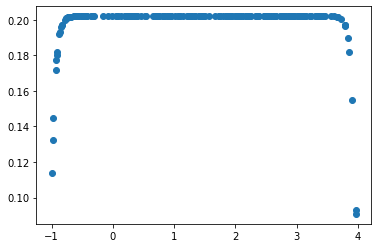

In [23]:
plt.scatter(inp.data.numpy(), yout.data.numpy())
plt.show()

In [24]:
yout

tensor([0.1966, 0.2020, 0.2020, 0.2020, 0.2020, 0.2020, 0.2020, 0.2020, 0.2020,
        0.2020, 0.1803, 0.2020, 0.2020, 0.1549, 0.2020, 0.2020, 0.2020, 0.2020,
        0.2017, 0.2020, 0.2020, 0.2020, 0.2020, 0.2010, 0.2020, 0.1933, 0.2020,
        0.2020, 0.2020, 0.2020, 0.1774, 0.2020, 0.2020, 0.2020, 0.1326, 0.2020,
        0.2020, 0.2020, 0.2020, 0.2020, 0.2020, 0.2020, 0.2020, 0.2020, 0.2020,
        0.1446, 0.1958, 0.2020, 0.2020, 0.2020, 0.2020, 0.1972, 0.2020, 0.2020,
        0.2020, 0.2020, 0.2020, 0.2020, 0.2020, 0.2020, 0.2020, 0.2020, 0.2020,
        0.1715, 0.2020, 0.2017, 0.2020, 0.2020, 0.2020, 0.2020, 0.2020, 0.2020,
        0.2020, 0.2020, 0.2019, 0.2020, 0.2015, 0.2020, 0.1972, 0.2020, 0.2020,
        0.2020, 0.2020, 0.1821, 0.2020, 0.2020, 0.2018, 0.2020, 0.2013, 0.0933,
        0.1968, 0.2020, 0.2020, 0.2020, 0.2020, 0.2020, 0.2014, 0.2020, 0.2020,
        0.2020, 0.2020, 0.2020, 0.2020, 0.2020, 0.2020, 0.1899, 0.2020, 0.2020,
        0.2020, 0.2020, 0.2020, 0.2020, 

In [25]:
torch.sum(yout)

tensor(39.7305, grad_fn=<SumBackward0>)

### Appriximate the area under the curve

In [26]:
mini, maxi = inp.min(), inp.max()
diff = maxi-mini

xs = torch.linspace(mini-diff, maxi+diff, steps=100000, dtype=torch.float32)

In [27]:
### for gaussian
ys = gaus(xs).data
width = xs[1:]-xs[:-1]
height = (ys[:-1]+ys[1:])/2
# height = ys[:-1]

areas = width*height
area = areas.sum()
area

tensor(1.0000)

In [28]:
### for bandpass
ys = bpas(xs).data
width = xs[1:]-xs[:-1]
height = (ys[:-1]+ys[1:])/2

areas = width*height
area = areas.sum()
area

tensor(1.0000)